In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.interpolate import interpolate
from utils.get_latent import get_latent_representation
import json
from scgpt.model import TransformerModel
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
from scgpt.tokenizer import GeneVocab
import anndata
from scgpt.tasks import embed_data

/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
adata = sc.read_h5ad("../data/emt.h5ad")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


In [38]:
model_dir = Path("../models/scgpt/") 

embed_adata = embed_data(
    adata,
    model_dir,
    gene_col='gene_short_name',       
    obs_to_save=["cell_type"],
    batch_size=64,
    return_new_adata=True,
)

adata.obsm["X_scgpt"] = embed_adata.X


scGPT - INFO - match 1789/2000 genes in vocabulary of size 60697.


/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/scgpt/model/model.py:77: UserWarning: flash-attn is not installed, using pytorch transformer instead. Set use_fast_transformer=False to avoid this warning. Installing flash-attn is highly recommended.
  warnings.warn(
Embedding cells: 100%|██████████| 79/79 [00:04<00:00, 17.58it/s]
/mnt/home/islamsa3/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [39]:
sc.pp.neighbors(adata, use_rep="X_scgpt", n_neighbors=30)
sc.tl.umap(adata)

In [40]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

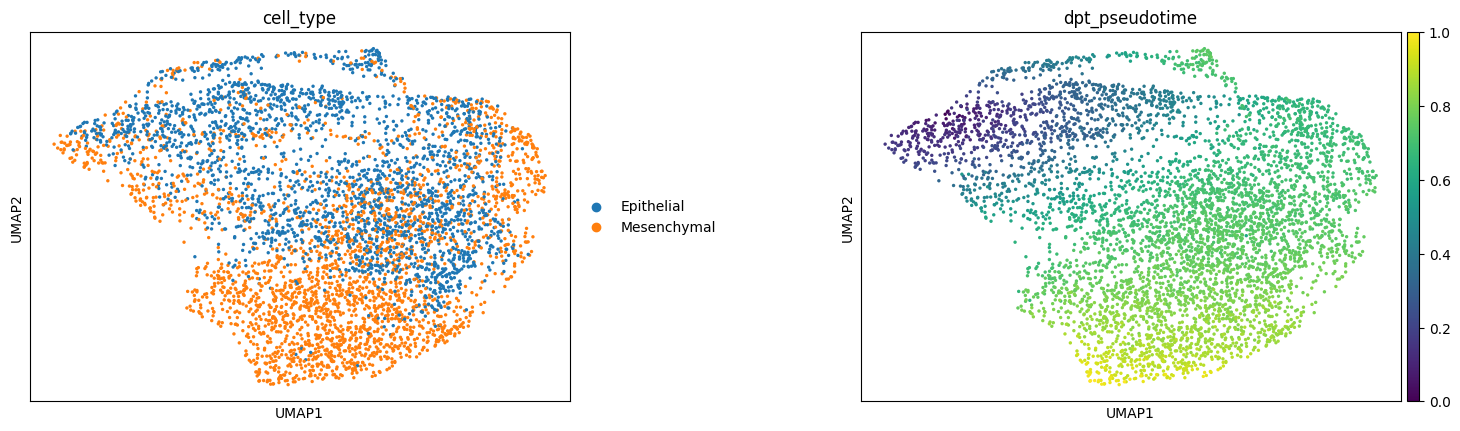

In [41]:
sc.pl.umap(
    adata,
    color=["cell_type", "dpt_pseudotime"],
    color_map="viridis",
    wspace=0.4,
)

In [42]:
z_E = adata.obsm['X_scgpt'][0]
z_M = adata.obsm['X_scgpt'][-1]

In [43]:
X_latent = adata.obsm["X_scgpt"]  

In [11]:
fig, ax = plt.subplots(figsize=(6, 5))

# real cells
sc = ax.scatter(
    adata.obsm["X_umap"][:, 0],
    adata.obsm["X_umap"][:, 1],
    c="lightgray",
    s=5,
    alpha=0.5,
)

# synthetic EMT trajectory
# alphas is the interpolation parameter from 0 (E) to 1 (M)
alphas = np.linspace(0.0, 1.0, 200)
traj = ax.scatter(
    synthetic_umap[:, 0],
    synthetic_umap[:, 1],
    c=alphas,
    s=60,
)

ax.plot(
    synthetic_umap[:, 0],
    synthetic_umap[:, 1],
    linewidth=2,
)

ax.text(
    synthetic_umap[0, 0],
    synthetic_umap[0, 1],
    "E",
    fontsize=10,
    ha="center",
    va="bottom",
)
ax.text(
    synthetic_umap[-1, 0],
    synthetic_umap[-1, 1],
    "M",
    fontsize=10,
    ha="center",
    va="bottom",
)

plt.colorbar(traj, ax=ax, label="EMT interpolation α (0=E, 1=M)")
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [44]:
# Load the pretrained model properly
model_dir = Path("../models/scgpt/") 
vocab_path = model_dir / "vocab.json"
args_path  = model_dir / "args.json"
ckpt_path  = model_dir / "best_model.pt"

# Load config + vocab
with open(args_path) as f:
    cfg = json.load(f)

vocab = GeneVocab.from_file(vocab_path)

# First, let's check the checkpoint to determine the correct n_cls
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.load(ckpt_path, map_location='cpu')

# Check the shape of the classification layer to determine n_cls
if 'cls_decoder.out_layer.weight' in state:
    n_cls = state['cls_decoder.out_layer.weight'].shape[0]
    print(f"Detected n_cls={n_cls} from checkpoint")
else:
    n_cls = 1  # fallback

# Build model from args.json with correct n_cls
model = TransformerModel(
    ntoken=len(vocab),
    d_model=cfg["embsize"],           
    nhead=cfg["nheads"],              
    d_hid=cfg["d_hid"],               
    nlayers=cfg["nlayers"],           
    nlayers_cls=cfg.get("n_layers_cls", 3),
    n_cls=n_cls,  # Use the detected n_cls from checkpoint            
    vocab=vocab,                      
    dropout=cfg["dropout"],           
    pad_token=cfg["pad_token"],       
    pad_value=cfg["pad_value"],       
    do_mvc=cfg["MVC"],                
    do_dab=False,                    
    use_batch_labels=False,           
    num_batch_labels=None,
    domain_spec_batchnorm=False,
    input_emb_style=cfg["input_emb_style"], 
    n_input_bins=cfg["n_bins"],             
    cell_emb_style="cls" if cfg["USE_CLS"] else "none",
    mvc_decoder_style="inner product",
    ecs_threshold=0.3,
    explicit_zero_prob=False,
    use_fast_transformer=False,  # Set to False to avoid flash-attn issues
    fast_transformer_backend="pytorch",
    pre_norm=False,
)

# Load checkpoint 
model.load_state_dict(state, strict=False)
model = model.to(device)
model.eval()

print(f"Model loaded successfully on {device}")

Detected n_cls=177 from checkpoint
Model loaded successfully on cuda


In [45]:
# Alternative simpler approach: Interpolate directly in expression space
def generate_trajectory_expression_simple(adata, z_start, z_end, n_cells=200):
    """
    Generate synthetic trajectory by interpolating in latent space,
    then finding nearest neighbors in the original data to get expression values.
    
    This is a simpler, more robust approach that doesn't require the decoder.
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Interpolate in latent space
    trajectory_latent = []
    for alpha in np.linspace(0, 1, n_cells):
        z_interp = (1 - alpha) * z_start + alpha * z_end
        trajectory_latent.append(z_interp)
    trajectory_latent = np.vstack(trajectory_latent)
    
    # For each synthetic latent point, find k nearest neighbors in real data
    # and average their expression
    k = 10  # number of neighbors
    
    # Fit KNN on real latent representations
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(adata.obsm['X_scgpt'])
    
    # Find neighbors for each synthetic point
    distances, indices = knn.kneighbors(trajectory_latent)
    
    # Weight by inverse distance
    weights = 1.0 / (distances + 1e-8)
    weights = weights / weights.sum(axis=1, keepdims=True)
    
    # Get expression values
    n_genes = adata.n_vars
    trajectory_expression = np.zeros((n_cells, n_genes))
    
    for i in range(n_cells):
        neighbor_idx = indices[i]
        neighbor_weights = weights[i]
        
        # Weighted average of neighbor expressions
        for j, idx in enumerate(neighbor_idx):
            trajectory_expression[i] += neighbor_weights[j] * adata.X[idx]
    
    return trajectory_latent

print("Defined simpler trajectory generation function")

Defined simpler trajectory generation function


In [46]:
# Generate synthetic EMT trajectory using the simpler approach
print("Generating synthetic EMT trajectory...")

# Get start and end points from the dataset
# Find epithelial and mesenchymal cells
epithelial_mask = adata.obs['cell_type'].str.contains('Epithelial', case=False, na=False)
mesenchymal_mask = adata.obs['cell_type'].str.contains('Mesenchymal', case=False, na=False)

# Get representative cells (you can use mean or specific cells)
z_E = adata.obsm['X_scgpt'][0]
z_M = adata.obsm['X_scgpt'][-1]

# Number of cells in trajectory
n_trajectory_cells = 200

# Generate trajectory using the simpler method
trajectory_latent = generate_trajectory_expression_simple(
    adata, z_E, z_M, n_trajectory_cells
)

print(f"Trajectory latent shape: {trajectory_latent.shape}")


gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

Generating synthetic EMT trajectory...
Trajectory latent shape: (200, 512)


In [47]:
def latent_to_gene_expression(latent_embeddings, model, vocab, gene_names, device='cuda'):
    """
    Convert latent embeddings back to gene expression space using the scGPT decoder.
    
    Args:
        latent_embeddings: numpy array or torch tensor of shape (n_cells, latent_dim)
        model: scGPT TransformerModel
        vocab: GeneVocab object
        gene_names: list of gene names from the dataset
        device: device to run the model on
    
    Returns:
        gene_expressions: numpy array of shape (n_cells, n_genes)
    """
    model.eval()
    
    # Convert to tensor if needed
    if isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = torch.from_numpy(latent_embeddings).float()
    
    # Ensure correct shape
    if len(latent_embeddings.shape) == 1:
        latent_embeddings = latent_embeddings.unsqueeze(0)
    
    latent_embeddings = latent_embeddings.to(device)
    n_cells = latent_embeddings.shape[0]
    
    # Get vocab mapping
    stoi = vocab.get_stoi()
    n_genes = len(gene_names)
    
    # Create gene token ids for genes in our dataset
    gene_ids = []
    valid_idx = []
    for i, gene in enumerate(gene_names):
        if gene in stoi:
            gene_ids.append(stoi[gene])
            valid_idx.append(i)
    
    gene_ids = torch.tensor(gene_ids, dtype=torch.long).to(device)
    n_valid_genes = len(gene_ids)
    
    with torch.no_grad():
        # Get gene embeddings from the model's encoder
        gene_embeddings = model.encoder(gene_ids)  # Shape: (n_valid_genes, d_model)
        
        # Try different decoder approaches based on what's available
        pred_values = None
        
        # Approach 1: Try MVC decoder if available
        if hasattr(model, 'mvc_decoder') and model.mvc_decoder is not None:
            try:
                # MVC decoder expects:
                # cell_emb: 2D tensor (batch, d_model)
                # gene_embs: 3D tensor (batch, n_genes, d_model)
                
                # Process in batches for efficiency
                batch_size = 32  # Process 32 cells at a time
                all_predictions = []
                
                for batch_start in range(0, n_cells, batch_size):
                    batch_end = min(batch_start + batch_size, n_cells)
                    batch_cells = latent_embeddings[batch_start:batch_end]  # (batch, d_model)
                    curr_batch_size = batch_cells.shape[0]
                    
                    # Prepare gene embeddings: expand to 3D with batch dimension
                    # Repeat gene embeddings for each cell in the batch
                    gene_embs_3d = gene_embeddings.unsqueeze(0).expand(curr_batch_size, -1, -1)
                    # Shape: (batch_size, n_genes, d_model)
                    
                    # Call MVC decoder
                    # cell_emb is already 2D: (batch_size, d_model)
                    # gene_embs is 3D: (batch_size, n_genes, d_model)
                    output = model.mvc_decoder(
                        cell_emb=batch_cells,
                        gene_embs=gene_embs_3d
                    )
                    
                    # Handle the output
                    if isinstance(output, dict):
                        if 'pred' in output:
                            batch_pred = output['pred']
                        elif 'output' in output:
                            batch_pred = output['output']
                        else:
                            batch_pred = list(output.values())[0]
                    else:
                        batch_pred = output
                    
                    # batch_pred should be (batch_size, n_genes)
                    all_predictions.append(batch_pred)
                
                # Concatenate all batch predictions
                pred_values = torch.cat(all_predictions, dim=0)  # (n_cells, n_valid_genes)
                print("Using MVC decoder")
                
            except Exception as e:
                print(f"MVC decoder failed: {e}")
                pred_values = None
        
        # Approach 2: Try regular decoder
        if pred_values is None and hasattr(model, 'decoder'):
            try:
                # Regular decoder approach
                # Expand dimensions to combine cell and gene embeddings
                cell_emb_expanded = latent_embeddings.unsqueeze(1).expand(-1, n_valid_genes, -1)
                gene_emb_expanded = gene_embeddings.unsqueeze(0).expand(n_cells, -1, -1)
                
                # Combine embeddings
                combined = cell_emb_expanded + gene_emb_expanded
                
                # Pass through decoder
                pred_values = model.decoder(combined)
                
                # Handle output shape
                if isinstance(pred_values, dict):
                    # If decoder returns a dict, extract the values
                    if 'mlm_output' in pred_values:
                        pred_values = pred_values['mlm_output']
                    elif 'x' in pred_values:
                        pred_values = pred_values['x']
                    else:
                        # Try to get the first tensor value
                        pred_values = list(pred_values.values())[0]
                
                if len(pred_values.shape) == 3 and pred_values.shape[-1] == 1:
                    pred_values = pred_values.squeeze(-1)
                print("Using standard decoder")
            except Exception as e:
                print(f"Standard decoder failed: {e}")
                pred_values = None
        
        # Approach 3: Direct projection as fallback
        if pred_values is None:
            print("Using direct projection fallback")
            
            # Simple linear projection
            # Create a projection based on dot product similarity
            pred_values = torch.matmul(latent_embeddings, gene_embeddings.T)
            
            # Apply some normalization/activation
            pred_values = torch.sigmoid(pred_values * 0.1)  # Scale and sigmoid
            pred_values = pred_values * 10  # Scale to expression range
        
        # Convert predictions back to numpy
        if isinstance(pred_values, torch.Tensor):
            pred_values = pred_values.cpu().numpy()
        
        # Ensure correct shape
        if len(pred_values.shape) == 1:
            pred_values = pred_values.reshape(1, -1)
        
        # Create full expression matrix
        full_expression = np.zeros((n_cells, n_genes))
        
        # Fill in the predicted values for genes in vocabulary
        for i, idx in enumerate(valid_idx):
            if i < pred_values.shape[1]:
                full_expression[:, idx] = pred_values[:, i]
    
    # Post-process to ensure reasonable values
    full_expression = np.maximum(full_expression, 0)  # Ensure non-negative
    
    return full_expression

In [48]:
def latent_to_gene_expression(latent_embeddings, model, vocab, gene_names, device='cuda'):
    """
    Convert latent embeddings back to gene expression space using the scGPT decoder.
    
    Args:
        latent_embeddings: numpy array or torch tensor of shape (n_cells, latent_dim)
        model: scGPT TransformerModel
        vocab: GeneVocab object
        gene_names: list of gene names from the dataset
        device: device to run the model on
    
    Returns:
        gene_expressions: numpy array of shape (n_cells, n_genes)
    """
    model.eval()
    
    # Convert to tensor if needed
    if isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = torch.from_numpy(latent_embeddings).float()
    
    # Ensure correct shape
    if len(latent_embeddings.shape) == 1:
        latent_embeddings = latent_embeddings.unsqueeze(0)
    
    latent_embeddings = latent_embeddings.to(device)
    n_cells = latent_embeddings.shape[0]
    
    # Get vocab mapping
    stoi = vocab.get_stoi()
    n_genes = len(gene_names)
    
    # Create gene token ids for genes in our dataset
    gene_ids = []
    valid_idx = []
    for i, gene in enumerate(gene_names):
        if gene in stoi:
            gene_ids.append(stoi[gene])
            valid_idx.append(i)
    
    gene_ids = torch.tensor(gene_ids, dtype=torch.long).to(device)
    n_valid_genes = len(gene_ids)
    
    with torch.no_grad():
        # Get gene embeddings from the model's encoder
        gene_embeddings = model.encoder(gene_ids)  # Shape: (n_valid_genes, d_model)
        
        # Try different decoder approaches based on what's available
        pred_values = None
        
        # Approach 1: Try MVC decoder if available
        if hasattr(model, 'mvc_decoder') and model.mvc_decoder is not None:
            try:
                # MVC decoder expects:
                # gene_embs: (batch, n_genes, d_model) 
                # cell_emb: (batch, d_model, n_cells) for bmm operation
                
                all_predictions = []
                
                # Process each cell individually
                for i in range(n_cells):
                    # Get single cell embedding
                    cell_emb_single = latent_embeddings[i:i+1]  # Shape: (1, d_model)
                    
                    # Prepare gene embeddings: (1, n_genes, d_model)
                    gene_embs_batch = gene_embeddings.unsqueeze(0)  # (1, n_genes, d_model)
                    
                    # Prepare cell embedding for bmm: needs to be (1, d_model, 1) 
                    cell_emb_batch = cell_emb_single.unsqueeze(2)  # (1, d_model, 1)
                    
                    # Call MVC decoder
                    output = model.mvc_decoder(
                        cell_emb=cell_emb_batch,
                        gene_embs=gene_embs_batch
                    )
                    
                    # Handle the output
                    if isinstance(output, dict):
                        if 'output' in output:
                            cell_pred = output['output']
                        elif 'pred' in output:
                            cell_pred = output['pred']
                        else:
                            cell_pred = list(output.values())[0]
                    else:
                        cell_pred = output
                    
                    # cell_pred should be (1, n_genes) or (n_genes,)
                    if len(cell_pred.shape) == 2:
                        cell_pred = cell_pred.squeeze(0)
                    
                    all_predictions.append(cell_pred)
                
                # Stack all predictions
                pred_values = torch.stack(all_predictions, dim=0)  # (n_cells, n_valid_genes)
                print("Using MVC decoder")
                
            except Exception as e:
                print(f"MVC decoder failed: {e}")
                pred_values = None
        
        # Approach 2: Try regular decoder
        if pred_values is None and hasattr(model, 'decoder'):
            try:
                # Regular decoder approach
                # Expand dimensions to combine cell and gene embeddings
                cell_emb_expanded = latent_embeddings.unsqueeze(1).expand(-1, n_valid_genes, -1)
                gene_emb_expanded = gene_embeddings.unsqueeze(0).expand(n_cells, -1, -1)
                
                # Combine embeddings
                combined = cell_emb_expanded + gene_emb_expanded
                
                # Pass through decoder
                pred_values = model.decoder(combined)
                
                # Handle output shape
                if isinstance(pred_values, dict):
                    # If decoder returns a dict, extract the values
                    if 'mlm_output' in pred_values:
                        pred_values = pred_values['mlm_output']
                    elif 'x' in pred_values:
                        pred_values = pred_values['x']
                    else:
                        # Try to get the first tensor value
                        pred_values = list(pred_values.values())[0]
                
                if len(pred_values.shape) == 3 and pred_values.shape[-1] == 1:
                    pred_values = pred_values.squeeze(-1)
                print("Using standard decoder")
            except Exception as e:
                print(f"Standard decoder failed: {e}")
                pred_values = None
        
        # Approach 3: Direct projection as fallback
        if pred_values is None:
            print("Using direct projection fallback")
            
            # Simple linear projection
            # Create a projection based on dot product similarity
            pred_values = torch.matmul(latent_embeddings, gene_embeddings.T)
            
            # Apply some normalization/activation
            pred_values = torch.sigmoid(pred_values * 0.1)  # Scale and sigmoid
            pred_values = pred_values * 10  # Scale to expression range
        
        # Convert predictions back to numpy
        if isinstance(pred_values, torch.Tensor):
            pred_values = pred_values.cpu().numpy()
        
        # Ensure correct shape
        if len(pred_values.shape) == 1:
            pred_values = pred_values.reshape(1, -1)
        
        # Create full expression matrix
        full_expression = np.zeros((n_cells, n_genes))
        
        # Fill in the predicted values for genes in vocabulary
        for i, idx in enumerate(valid_idx):
            if i < pred_values.shape[1]:
                full_expression[:, idx] = pred_values[:, i]
    
    # Post-process to ensure reasonable values
    full_expression = np.maximum(full_expression, 0)  # Ensure non-negative
    
    return full_expression

In [49]:
z_E = adata.obsm['X_scgpt'][0]
z_M = adata.obsm['X_scgpt'][-1]

# Number of cells in trajectory
n_trajectory_cells = 200

# Interpolate in latent space
trajectory_latent = []
for alpha in np.linspace(0, 1, n_trajectory_cells):
    z_interp = (1 - alpha) * z_E + alpha * z_M
    trajectory_latent.append(z_interp)

trajectory_latent = np.vstack(trajectory_latent)
print(f"Trajectory latent shape: {trajectory_latent.shape}")

# Convert latent embeddings to gene expression using the decoder
gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate gene expressions for the trajectory
trajectory_expression = latent_to_gene_expression(
    trajectory_latent, 
    model, 
    vocab, 
    gene_names,
    device=device
)

print(f"Generated trajectory expression shape: {trajectory_expression.shape}")
print(f"Expression value range: [{trajectory_expression.min():.3f}, {trajectory_expression.max():.3f}]")
print(f"Mean expression: {trajectory_expression.mean():.3f}")
print(f"Sparsity: {(trajectory_expression == 0).mean():.2%}")

Trajectory latent shape: (200, 512)
MVC decoder failed: batch2 must be a 3D tensor
Using standard decoder
Generated trajectory expression shape: (200, 2000)
Expression value range: [0.000, 14.649]
Mean expression: 5.329
Sparsity: 12.90%


In [50]:
adata_interpolated_cells = anndata.AnnData(trajectory_expression)

In [51]:
adata_interpolated_cells.var_names = adata.var_names

In [52]:
adata_new = anndata.AnnData(
    X=adata.X,
    obs=adata.obs[['cell_type']].copy()
)
adata_new.var_names = adata.var_names

In [53]:
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'
adata_interpolated_cells

AnnData object with n_obs × n_vars = 200 × 2000
    obs: 'cell_type'

In [54]:
combined_adata = anndata.concat([adata_new, adata_interpolated_cells], join='inner')
combined_adata

AnnData object with n_obs × n_vars = 5227 × 2000
    obs: 'cell_type'

/mnt/gs21/scratch/islamsa3/fm-project/.conda/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


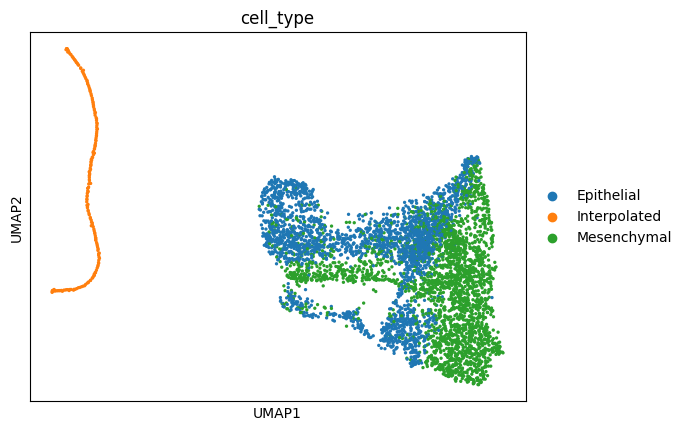

In [55]:
sc.pp.neighbors(combined_adata)  
sc.tl.umap(combined_adata)

sc.pl.umap(combined_adata, color='cell_type')

Available epithelial markers: ['CDH1', 'EPCAM', 'KRT18', 'CLDN4', 'CLDN7']
Available mesenchymal markers: ['VIM', 'FN1', 'SNAI2']


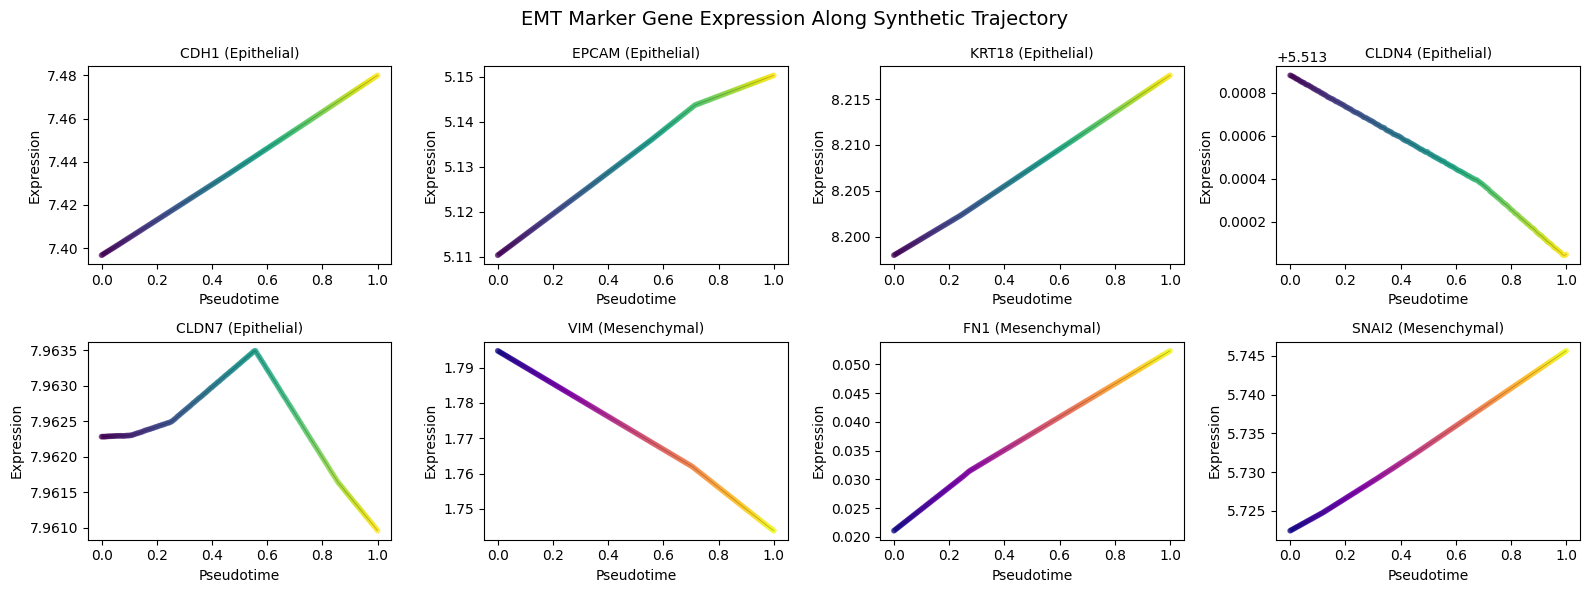

In [56]:
# Analyze EMT marker genes along the trajectory
# Common EMT markers
epithelial_markers = ['CDH1', 'EPCAM', 'KRT19', 'KRT18', 'CLDN3', 'CLDN4', 'CLDN7']
mesenchymal_markers = ['VIM', 'CDH2', 'FN1', 'SNAI1', 'SNAI2', 'TWIST1', 'ZEB1', 'ZEB2']

# Find which markers are in our dataset
available_epithelial = [g for g in epithelial_markers if g in gene_names]
available_mesenchymal = [g for g in mesenchymal_markers if g in gene_names]

print(f"Available epithelial markers: {available_epithelial}")
print(f"Available mesenchymal markers: {available_mesenchymal}")

# Plot expression patterns along trajectory
if available_epithelial or available_mesenchymal:
    n_markers = len(available_epithelial) + len(available_mesenchymal)
    n_cols = min(4, n_markers)
    n_rows = (n_markers + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,200)
    
    plot_idx = 0
    # Plot epithelial markers
    for gene in available_epithelial:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = trajectory_expression[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Epithelial)', fontsize=10)
        plot_idx += 1
    
    # Plot mesenchymal markers
    for gene in available_mesenchymal:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = trajectory_expression[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='plasma', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mesenchymal)', fontsize=10)
        plot_idx += 1
    
    # Hide unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('EMT Marker Gene Expression Along Synthetic Trajectory', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No common EMT markers found in the dataset")

In [57]:
adata_interpolated_cells.X[0]

array([5.53246164, 6.58123302, 0.06710799, ..., 7.17782831, 0.        ,
       0.        ])

In [58]:
adata.X[-1].toarray()

array([[0.        , 0.91339058, 0.91339058, ..., 4.5385081 , 1.38266785,
        0.        ]])